In [4]:
!pip install pydicom pynetdicom

In [5]:
import pydicom
from pydicom.dataset import Dataset

from pynetdicom import AE
from pynetdicom.status import Status

In [6]:
import urllib.request
filename = "brain.dcm"
url = "https://github.com/sgsfak/BME-Medical-Informatics-course/blob/main/dicom/brain.dcm?raw=true"
urllib.request.urlretrieve(url, filename)
ds = pydicom.dcmread(filename)
ds[(0x0008, 0x0020)]

(0008, 0020) Study Date                          DA: '20061219'

In [7]:
print(ds.PatientName)
print(ds[0x10,0x10].value)

Single^Brain
Single^Brain


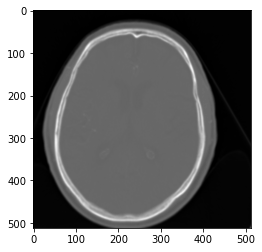

In [9]:
import matplotlib.pyplot as plt
plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
plt.show()

## C-ECHO

In [11]:
ae = AE(ae_title="BMEVIEWER")
ae.add_requested_context('1.2.840.10008.1.1')
assoc = ae.associate('bme-course.duckdns.org', 4242)
status = assoc.send_c_echo()
print(Status.SUCCESS.value)
print(status.Status)

0
0


## C-FIND

In [21]:
from pynetdicom.sop_class import PatientRootQueryRetrieveInformationModelFind
# Create our Identifier (query) dataset
ds = Dataset()
ds.PatientName = 'Single*' # Find all patients with surname like 'Single..'
ds.PatientID = ''
ds.PatientBirthDate = ''
ds.QueryRetrieveLevel = 'PATIENT'

ae = AE(ae_title='BMEVIEWER')
ae.add_requested_context(PatientRootQueryRetrieveInformationModelFind)

results = []

assoc = ae.associate('bme-course.duckdns.org', 4242)
if assoc.is_established:
    # Send the C-FIND request
    responses = assoc.send_c_find(ds, PatientRootQueryRetrieveInformationModelFind)
    for (status, ds) in responses:
        if status:
            print('C-FIND query status: 0x{0:04X} {1} {2}'.format(status.Status, ds and ds.PatientName or '', ds and ds.PatientID or ''))
            if ds:
                results.append(ds)
        else:
            print('Connection timed out, was aborted or received invalid response')

    # Release the association
    assoc.release()
else:
    print('Association rejected, aborted or never connected')

C-FIND query status: 0xFF00 Single^Coronary 0106
C-FIND query status: 0xFF00 Single^Brain 0105
C-FIND query status: 0xFF00 Single^Neck 0104
C-FIND query status: 0xFF00 Single^CardiacCalcium 0101
C-FIND query status: 0xFF00 Single^Chest LUL Mass 0102
C-FIND query status: 0x0000  


In [22]:
len(results)

5

In [23]:
results[0]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0052) Query/Retrieve Level                CS: 'PATIENT'
(0008, 0054) Retrieve AE Title                   AE: 'ORTHANC'
(0010, 0010) Patient's Name                      PN: 'Single^Coronary'
(0010, 0020) Patient ID                          LO: '0106'
(0010, 0030) Patient's Birth Date                DA: '19500704'

In [24]:
ds = Dataset()
ds.PatientID = results[0].PatientID
ds.StudyDate = ''
ds.StudyInstanceUID=''
ds.QueryRetrieveLevel = 'STUDY'

ae = AE(ae_title='BMEVIEWER')
ae.add_requested_context(PatientRootQueryRetrieveInformationModelFind)

studies = []

assoc = ae.associate('bme-course.duckdns.org', 4242)
if assoc.is_established:
    # Send the C-FIND request
    responses = assoc.send_c_find(ds, PatientRootQueryRetrieveInformationModelFind)
    for (status, ds) in responses:
        if status:
            print('C-FIND query status: 0x{0:04X}'.format(status.Status))
            if ds:
                studies.append(ds)
        else:
            print('Connection timed out, was aborted or received invalid response')

    # Release the association
    assoc.release()
else:
    print('Association rejected, aborted or never connected')

C-FIND query status: 0xFF00
C-FIND query status: 0x0000


In [25]:
studies[0]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0020) Study Date                          DA: '20061219'
(0008, 0052) Query/Retrieve Level                CS: 'STUDY'
(0008, 0054) Retrieve AE Title                   AE: 'ORTHANC'
(0010, 0020) Patient ID                          LO: '0106'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.5962.1.2.106.1166562673.14401

In [26]:
from pynetdicom.sop_class import StudyRootQueryRetrieveInformationModelFind
ds = Dataset()
ds.SeriesInstanceUID = ''
ds.PatientID = '0106'
ds.StudyInstanceUID='1.3.6.1.4.1.5962.1.2.106.1166562673.14401'
ds.QueryRetrieveLevel = 'SERIES'

ae = AE(ae_title='BMEVIEWER')
ae.add_requested_context(StudyRootQueryRetrieveInformationModelFind)

series = []

assoc = ae.associate('bme-course.duckdns.org', 4242)
if assoc.is_established:
    # Send the C-FIND request
    responses = assoc.send_c_find(ds, StudyRootQueryRetrieveInformationModelFind)
    for (status, ds) in responses:
        if status:
            print('C-FIND query status: 0x{0:04X}'.format(status.Status))
            if ds:
                series.append(ds)
        else:
            print('Connection timed out, was aborted or received invalid response')

    # Release the association
    assoc.release()
else:
    print('Association rejected, aborted or never connected')

C-FIND query status: 0xFF00
C-FIND query status: 0x0000


In [27]:
series[0]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0052) Query/Retrieve Level                CS: 'SERIES'
(0008, 0054) Retrieve AE Title                   AE: 'ORTHANC'
(0010, 0020) Patient ID                          LO: '0106'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.5962.1.2.106.1166562673.14401
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.5962.1.3.106.1.1166562673.14401

In [28]:
ds = Dataset()
ds.SeriesInstanceUID= series[0].SeriesInstanceUID
ds.QueryRetrieveLevel = 'IMAGE'
ds.SOPInstanceUID = ''
ds.Columns= ''
ds.Modality=''
ds.Rows= ''

ae = AE(ae_title='BMEVIEWER')
ae.add_requested_context(PatientRootQueryRetrieveInformationModelFind)

images = []

assoc = ae.associate('bme-course.duckdns.org', 4242)
if assoc.is_established:
    # Send the C-FIND request
    responses = assoc.send_c_find(ds, PatientRootQueryRetrieveInformationModelFind)
    for (status, ds) in responses:
        if status:
            print('C-FIND query status: 0x{0:04X}'.format(status.Status))
            if ds:
                images.append(ds)
        else:
            print('Connection timed out, was aborted or received invalid response')

    # Release the association
    assoc.release()
else:
    print('Association rejected, aborted or never connected')

C-FIND query status: 0xFF00
C-FIND query status: 0x0000


In [29]:
images[0]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.5962.1.1.106.1.1.1166562673.14401
(0008, 0052) Query/Retrieve Level                CS: 'IMAGE'
(0008, 0054) Retrieve AE Title                   AE: 'ORTHANC'
(0008, 0060) Modality                            CS: 'CT'
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.5962.1.3.106.1.1166562673.14401
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512

## C-GET

In [30]:
from pynetdicom import evt, build_role, debug_logger
from pynetdicom.sop_class import CTImageStorage
from pynetdicom.sop_class import PatientRootQueryRetrieveInformationModelGet

debug_logger()

# Implement the handler for evt.EVT_C_STORE
def handle_store(event):
    """Handle a C-STORE request event."""
    ds = event.dataset
    ds.file_meta = event.file_meta

    print("Writing to " + ds.SOPInstanceUID)
    ## Save the dataset using the SOP Instance UID as the filename
    # ds.save_as(ds.SOPInstanceUID, write_like_original=False)

    # Return a 'Success' status
    return 0x0000

handlers = [(evt.EVT_C_STORE, handle_store)]

# Initialise the Application Entity
ae = AE(ae_title='BMEVIEWER')

# Add the requested presentation contexts (QR SCU)
ae.add_requested_context(PatientRootQueryRetrieveInformationModelGet)
# Add the requested presentation context (Storage SCP)

from pydicom.uid import UID
enhancedCTImageStore = UID('1.2.840.10008.5.1.4.1.1.2.1')

ae.add_requested_context(enhancedCTImageStore)

# Create an SCP/SCU Role Selection Negotiation item for CT Image Storage
role = build_role(enhancedCTImageStore, scp_role=True)

# Create our Identifier (query) dataset
# We need to supply a Unique Key Attribute for each level above the
#   Query/Retrieve level
ds = Dataset()
ds.QueryRetrieveLevel = 'SERIES'
# Unique key for PATIENT level
ds.PatientID = '0106'
# Unique key for STUDY level
ds.StudyInstanceUID = '1.3.6.1.4.1.5962.1.2.106.1166562673.14401'
# Unique key for SERIES level
ds.SeriesInstanceUID = '1.3.6.1.4.1.5962.1.3.106.1.1166562673.14401'

# Associate with peer AE 
assoc = ae.associate('bme-course.duckdns.org', 4242, ext_neg=[role], evt_handlers=handlers)

if assoc.is_established:
    # Use the C-GET service to send the identifier
    responses = assoc.send_c_get(ds, PatientRootQueryRetrieveInformationModelGet)
    for (status, identifier) in responses:
        if status:
            print('C-GET query status: 0x{0:04x}'.format(status.Status))
        else:
            print('Connection timed out, was aborted or received invalid response')

    # Release the association
    assoc.release()
else:
    print('Association rejected, aborted or never connected')


I: Requesting Association
D: Request Parameters:
D: ======================= OUTGOING A-ASSOCIATE-RQ PDU ========================
D: Our Implementation Class UID:      1.2.826.0.1.3680043.9.3811.1.5.7
D: Our Implementation Version Name:   PYNETDICOM_157
D: Application Context Name:    1.2.840.10008.3.1.1.1
D: Calling Application Name:    BMEVIEWER       
D: Called Application Name:     ANY-SCP         
D: Our Max PDU Receive Size:    16382
D: Presentation Contexts:
D:   Context ID:        1 (Proposed)
D:     Abstract Syntax: =Patient Root Query/Retrieve Information Model - GET
D:     Proposed SCP/SCU Role: Default
D:     Proposed Transfer Syntaxes:
D:       =Implicit VR Little Endian
D:       =Explicit VR Little Endian
D:       =Deflated Explicit VR Little Endian
D:       =Explicit VR Big Endian
D:   Context ID:        3 (Proposed)
D:     Abstract Syntax: =Enhanced CT Image Storage
D:     Proposed SCP/SCU Role: SCP
D:     Proposed Transfer Syntaxes:
D:       =Implicit VR Little Endian
D

Writing to 1.3.6.1.4.1.5962.1.1.106.1.1.1166562673.14401
C-GET query status: 0xff00
C-GET query status: 0x0000
